## DOWNSTREAM SIGNALING DYNAMICS

## PCA

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from msresist.pca import pca_dfs

In [2]:
# Set plotting format
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [3]:
def plotPCA(ax, d, n_components, scores_ind, loadings_ind, hue_scores=None, style_scores=None, size_dots=100, pvals=None, style_load=None, legendOut=False, quadrants=True):
    """ Plot PCA scores and loadings. """
    pp = PCA(n_components=n_components)
    dScor_ = pp.fit_transform(d.select_dtypes(include=["float64"]))
    dLoad_ = pp.components_
    dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, d, n_components, scores_ind, loadings_ind)
    varExp = np.round(pp.explained_variance_ratio_, 2)

    # Scores
    sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue=hue_scores, style=style_scores, ax=ax[0], **{"linewidth": 0.5, "edgecolor": "k"}, s=size_dots)
    ax[0].set_title("PCA Scores")
    ax[0].set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=10)
    ax[0].set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=10)
    ax[0].legend(prop={'size': 8})
    if legendOut:
        ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, prop={'size': 8})

    # Loadings
    if isinstance(pvals, np.ndarray):
        dLoad_["p-value"] = pvals
        sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="p-value", style=style_load, ax=ax[1], **{"linewidth": 0.5, "edgecolor": "k"}, s=100)
    else:
        sns.scatterplot(x="PC1", y="PC2", data=dLoad_, style=style_load, ax=ax[1], **{"linewidth": 0.5, "edgecolor": "k"}, s=100)

    ax[1].set_title("PCA Loadings")
    ax[1].set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=10)
    ax[1].set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=10)
    ax[1].legend(prop={'size': 8})
    for j, txt in enumerate(dLoad_[loadings_ind]):
        ax[1].annotate(txt, (dLoad_["PC1"][j] + 0.001, dLoad_["PC2"][j] + 0.001), fontsize=10)

    if quadrants:
        ax[0].axhline(0, ls='--', color='lightgrey')
        ax[0].axvline(0, ls='--', color='lightgrey')
        ax[1].axhline(0, ls='--', color='lightgrey')
        ax[1].axvline(0, ls='--', color='lightgrey')

In [40]:
ts = pd.read_csv("msresist/data/Validations/Luminex/AXLm_TimeSeries_Signaling.csv")
ts.iloc[:, 3:] = pd.DataFrame(StandardScaler().fit_transform(ts.iloc[:, 3:]))
# ts["Time point"] = ts["Time point"].replace(0, 1)
# ts["Time point"] = ts["Time point"].replace(5, 50)
# ts["Time point"] = ts["Time point"].replace(10, 100)
# ts["Time point"] = ts["Time point"].replace(30, 150)
# ts["Time point"] = ts["Time point"].replace(60, 250)
# ts["Time point"] = ts["Time point"].replace(120, 350)
# ts["Time point"] = ts["Time point"].replace(240, 450)

# ts = ts.set_index("Cell Line")
# for cl, idx in list(zip(ts.index.values, np.arange(ts.shape[0]))):
#     ts.iloc[idx, 2:] /= ts.loc[cl].iloc[0, 2:]
# ts = ts.reset_index()

In [22]:
# ts = ts.reset_index().set_index("Treatment").drop("UT").reset_index()
# ts.iloc[:, 3:] = StandardScaler(with_std=False).fit_transform(ts.iloc[:, 3:])

No handles with labels found to put in legend.


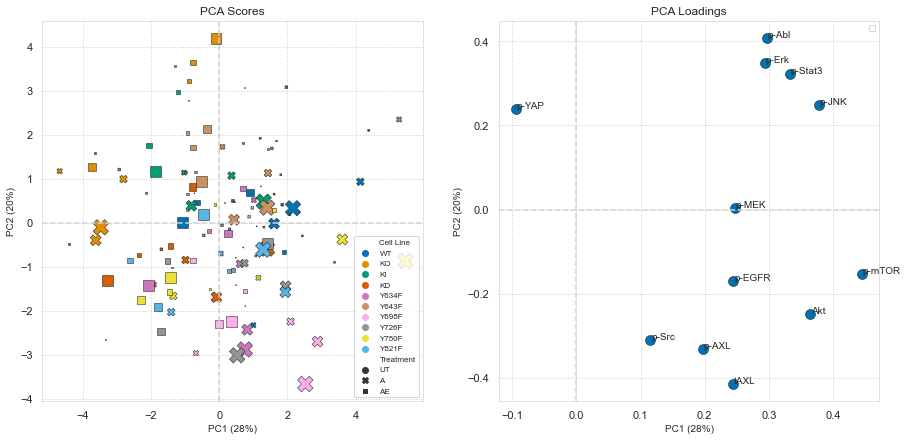

In [23]:
_, ax = plt.subplots(1, 2, figsize=(15, 7))
plotPCA(ax, ts, 2, ["Cell Line", "Treatment"], ts.columns[3:], hue_scores="Cell Line", style_scores="Treatment", size_dots=list(ts["Time point"]))

## TENSOR DECOMPOSITION

### 1. Treatment (2) x Cell Line (10) x Time point (7) x Analyte (12) Tensor

In [64]:
# a = ts[(ts["Treatment"] == "UT") | (ts["Treatment"] == "A")].iloc[:, 3:].values.reshape((10, 7, 12))
# ae = ts[(ts["Treatment"] == "UT") | (ts["Treatment"] == "AE")].iloc[:, 3:].values.reshape((10, 7, 12))
# out = np.array([a, ae])
# print(out.shape)

### 2. Cell Line (10) x Time point & Treatment (14) x Analyte (12) Tensor

First need to duplicate rows when t=0h at the right location to be able to reshape. 

In [65]:
# Function to insert row in the dataframe
def insert_rows(row_number, df, row_value):
    # Slice the upper half of the dataframe
    df1 = df[0:row_number]
  
    # Store the result of lower half of the dataframe
    df2 = df[row_number:]
  
    # Insert the row in the upper half dataframe
    df1.loc[row_number]=row_value
  
    # Concat the two dataframes
    df_result = pd.concat([df1, df2])
  
    # Reassign the index labels
    df_result.index = [*range(df_result.shape[0])]
  
    # Return the updated dataframe
    return df_result
  
# Let's create a row which we want to insert
ut_df = ts[ts["Treatment"] == "UT"]
row_numbers = ut_df.index
row_value = ut_df

ts_ = ts.copy()
for ii, rN in enumerate(row_numbers):
    ts_ = insert_rows(rN + ii, ts_, row_value.iloc[ii, :])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [74]:
out = ts_.iloc[:, 3:].values.reshape((14, 10, 12))

In [75]:
from tensorly.decomposition import parafac
import tensorly as tl

fac = parafac(out, 2, tol=1e-9, n_iter_max=1000)
fac = tl.cp_tensor.cp_flip_sign(fac)

In [76]:
# data variance
dvar = np.sum(np.square(out))
diffvar = np.sum(np.square(out - tl.cp_to_tensor(fac)))

# R2X
print(1.0 - diffvar / dvar)

0.2716589923579009


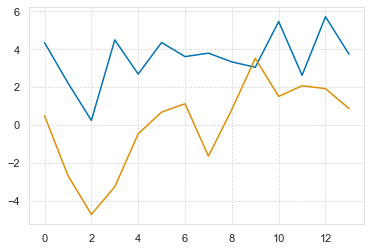

In [77]:
# First mode factors
plt.plot(fac.factors[0]);

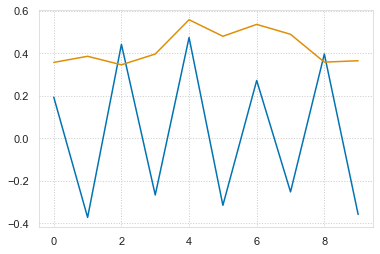

In [78]:
# Second mode factors
plt.plot(fac.factors[1]);

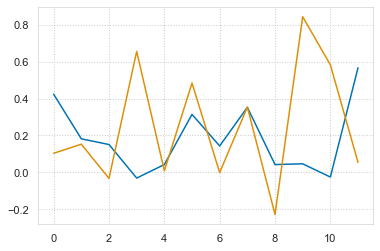

In [79]:
# Third mode factors
plt.plot(fac.factors[2]);